In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
import pandas as pd
import time
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [2]:
tf.random.set_seed(42)

In [3]:
#Getting the data
batch_size = 128
target_size = (48,48)
train_dir = "fer2013plus/fer2013/train/"
test_dir = "fer2013plus/fer2013/test/"
train_dataGenerator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                               horizontal_flip=True,
                                                               validation_split=0.2)
train_ds = train_dataGenerator.flow_from_directory(train_dir,
                                                        batch_size=batch_size,
                                                        target_size=target_size, 
                                                        shuffle=True,
                                                        class_mode='categorical',
                                                        color_mode="grayscale", 
                                                        subset='training')
validation_ds = train_dataGenerator.flow_from_directory(train_dir,
                                                        batch_size=batch_size,
                                                        target_size=target_size,
                                                        shuffle=True,
                                                        class_mode='categorical',
                                                        color_mode="grayscale", 
                                                        subset='validation')

test_dataGenerator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                              horizontal_flip=True)
test_ds = test_dataGenerator.flow_from_directory(test_dir,
                                                  batch_size=batch_size,
                                                  target_size=target_size,
                                                  shuffle=True,
                                                  color_mode="grayscale", 
                                                  class_mode="categorical")

Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.


In [4]:
def build_dcnn(input_shape, num_classes):
    model_in = Input(shape=input_shape, name="input")
    
    conv2d_1 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        
        kernel_initializer='he_normal',  
        
        name='conv2d_1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(batchnorm_2)
    
    dropout_1 = Dropout(0.2, name='dropout_1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(batchnorm_4)
    dropout_2 = Dropout(0.2, name='dropout_2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,  # Increasing learning capacity and feature extraction
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(batchnorm_6)

    dropout_3 = Dropout(0.2, name='dropout_3')(maxpool2d_3)

    flatten = Flatten(name='flatten')(dropout_3)
    
    dense_1 = Dense(
        128,   # 128 input neurons
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7')(dense_1)
    dropout_4 = Dropout(0.4, name='dropout_4')(batchnorm_7)

    model_out = Dense(
        num_classes,
        activation='softmax',
        name='out_layer',
        kernel_initializer=tf.keras.initializers.HeNormal()
    )(dropout_4)

    model = Model(inputs=model_in, outputs=model_out, name="DCNN")
    
    return model

In [5]:
model = build_dcnn(input_shape=(48,48,1), num_classes=8)
model.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0      

In [6]:
model.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(0.01),
             metrics=["accuracy"])

In [7]:
#Callback functions
early_stopping = EarlyStopping(
    monitor='val_loss',    
    min_delta=0.00001,      
    patience=8,            
    verbose=1,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',  #val_loss no overfitting   
    min_delta=0.0001,  
    mode="min",
    factor=0.5,                 
    patience=6,                 
    min_lr=1e-7,                
    verbose=1                   
)

checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', 
                         verbose=1, save_best_only=True, mode='max')

In [8]:
# aug_datagen = ImageDataGenerator(
# #     width_shift_range=0.15,
# #     height_shift_range=0.15,
# #     shear_range=0.15,
#     zoom_range=0.15,
#     horizontal_flip=True,
#     validation_split=0.2
# )

In [9]:
# aug_train_ds = aug_datagen.flow_from_directory(train_dir,
#                                                target_size=target_size,
#                                               batch_size=batch_size,
#                                               color_mode="grayscale",
#                                               class_mode="categorical",
#                                               subset="training")
# aug_validation_ds = aug_datagen.flow_from_directory(train_dir,
#                                                target_size=target_size,
#                                               batch_size=batch_size,
#                                               color_mode="grayscale",
#                                               class_mode="categorical",
#                                               subset="validation")

In [10]:
#Fitting the data
start = time.time()
history = model.fit(train_ds,
                   validation_data = validation_ds,
                   epochs=50,
                   callbacks=[early_stopping, lr_scheduler, checkpoint])
end = time.time()

Epoch 1/50


178/178 [==============================] - ETA: 0s - loss: 1.5389 - accuracy: 0.4550
Epoch 1: val_accuracy improved from -inf to 0.47515, saving model to model.h5
178/178 [==============================] - 21s 78ms/step - loss: 1.5389 - accuracy: 0.4550 - val_loss: 1.4434 - val_accuracy: 0.4751 - lr: 0.0100
Epoch 2/50
  1/178 [..............................] - ETA: 15s - loss: 1.1484 - accuracy: 0.5859

/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - ETA: 0s - loss: 1.0385 - accuracy: 0.6363
Epoch 2: val_accuracy improved from 0.47515 to 0.66602, saving model to model.h5
178/178 [==============================] - 11s 64ms/step - loss: 1.0385 - accuracy: 0.6363 - val_loss: 0.9566 - val_accuracy: 0.6660 - lr: 0.0100
Epoch 3/50
178/178 [==============================] - ETA: 0s - loss: 0.8503 - accuracy: 0.7022
Epoch 3: val_accuracy did not improve from 0.66602
178/178 [==============================] - 11s 63ms/step - loss: 0.8503 - accuracy: 0.7022 - val_loss: 1.1524 - val_accuracy: 0.6091 - lr: 0.0100
Epoch 4/50
178/178 [==============================] - ETA: 0s - loss: 0.7712 - accuracy: 0.7280
Epoch 4: val_accuracy improved from 0.66602 to 0.71043, saving model to model.h5
178/178 [==============================] - 11s 64ms/step - loss: 0.7712 - accuracy: 0.7280 - val_loss: 0.8106 - val_accuracy: 0.7104 - lr: 0.0100
Epoch 5/50
178/178 [==============================] - ETA: 0s - loss: 0.

In [12]:
import pickle
with open(f"time_var/dcnn-rtx3050", 'wb') as file:
    pickle.dump(end-start, file)

In [166]:
model.evaluate(test_ds)

56/56 [==============================] - 7s 121ms/step - loss: 0.6059 - accuracy: 0.7857


[0.6058780550956726, 0.7857444882392883]

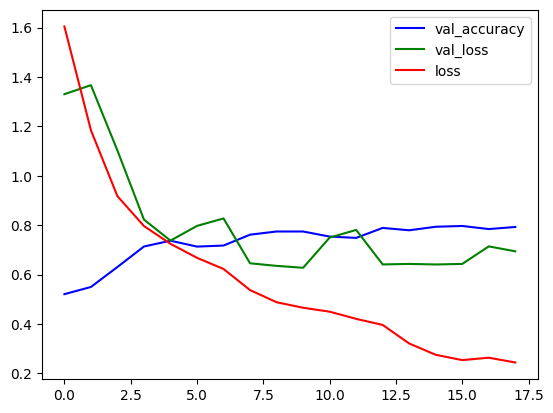

In [167]:
plt.plot(history.history["val_accuracy"], color="blue")
#plt.plot(history.history["accuracy"], color="red")
plt.plot(history.history["val_loss"], color="green")
plt.plot(history.history["loss"], color="red")
plt.legend(["val_accuracy","val_loss","loss"])
plt.show()

In [18]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}

In [26]:
y_pred = model.predict(test_ds)

57/57 [==============================] - 6s 109ms/step


In [45]:
from skimage import io
img = tf.keras.preprocessing.image.load_img('fer2013/test/angry/PrivateTest_1054527.jpg', grayscale=True, target_size=(48, 48))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

imgs_array

y = model.predict(img_array)
y_pred = np.argmax(y , axis = 1 )
y_pred

1/1 [==============================] - 0s 40ms/step


array([2])

In [168]:
model.save("high")

INFO:tensorflow:Assets written to: high/assets


INFO:tensorflow:Assets written to: high/assets
